In [39]:
import pandas as pd
from sqlalchemy import create_engine, text

# Connection setup
engine = create_engine(
    "oracle+oracledb://",
    connect_args={
        "user": "raw_layer",
        "password": "Raw#123",
        "dsn": "localhost:1521/XEPDB1",
    },
    pool_pre_ping=True,
)

with engine.begin() as conn:
    # ✅ Query all tables visible to the current user
    query = text("""
        SELECT table_name
        FROM user_tables
        ORDER BY table_name
    """)
    tables = pd.read_sql(query, conn)
    print("📋 Tables found:")
    print(tables)

📋 Tables found:
       table_name
0        BRANCHES
1            CARS
2  CAR_CATEGORIES
3       CUSTOMERS
4      IOT_ALERTS
5     IOT_DEVICES
6   IOT_TELEMETRY
7        MANAGERS
8        PAYMENTS
9         RENTALS


In [40]:
IOT_TELEMETRY  = pd.read_sql("SELECT * FROM IOT_TELEMETRY", engine)
IOT_TELEMETRY.head()

,telemetry_id,device_id,car_id,rental_id,timestamp,latitude,longitude,speed_kmh,acceleration_ms2,brake_pressure_bar,fuel_level_pct,battery_voltage,engine_temp_c,odometer_km,event_type,created_at
0,41201,1011,1076,211,2025-10-29 00:36:07,33.5731,-7.5898,0.0,0.0,0.0,40.82,12.31,50.49,12011,IDLE,2025-10-28 23:08:03
1,41202,1011,1076,211,2025-10-29 00:36:37,33.5731,-7.5898,0.0,0.0,0.0,40.82,12.29,43.88,12011,IDLE,2025-10-28 23:08:03
2,41203,1011,1076,211,2025-10-29 00:37:07,33.5731,-7.5898,0.0,0.0,0.0,40.82,12.41,40.28,12011,IDLE,2025-10-28 23:08:03
3,41204,1011,1076,211,2025-10-29 00:37:37,33.5731,-7.5898,0.0,0.0,0.0,40.82,12.42,59.49,12011,IDLE,2025-10-28 23:08:03
4,41205,1011,1076,211,2025-10-29 00:38:07,33.5731,-7.5898,0.0,0.0,0.0,40.82,12.55,42.53,12011,IDLE,2025-10-28 23:08:03


In [41]:
from geopy.distance import geodesic

# Loop through all rentals
for rid in sorted(IOT_TELEMETRY['rental_id'].unique()):
    rental_data = IOT_TELEMETRY[IOT_TELEMETRY['rental_id'] == rid].sort_values('timestamp')
    if rental_data.empty:
        continue

    # Extract start and end points
    first_lat, first_lon = rental_data.iloc[0][['latitude', 'longitude']]
    last_lat, last_lon = rental_data.iloc[-1][['latitude', 'longitude']]
    last_date = rental_data.iloc[-1]['timestamp']

    # Compute distance between start and end
    dist_km = geodesic((first_lat, first_lon), (last_lat, last_lon)).km

    # Print results
    print(f"📍 Rental ID: {rid}")
    print(f"  Start Location → Latitude: {first_lat:.6f}, Longitude: {first_lon:.6f}")
    print(f"  End Location   → Latitude: {last_lat:.6f}, Longitude: {last_lon:.6f}")
    print(f"  ➜ Distance between start and end: {dist_km:.2f} km")
    if dist_km > 1:
        print("  ⚠️  Potential anomaly (different start & end locations)")
    print("-" * 70)

📍 Rental ID: 211
  Start Location → Latitude: 33.573100, Longitude: -7.589800
  End Location   → Latitude: 33.573100, Longitude: -7.589800
  ➜ Distance between start and end: 0.00 km
----------------------------------------------------------------------
📍 Rental ID: 212
  Start Location → Latitude: 34.020900, Longitude: -6.841600
  End Location   → Latitude: 34.020900, Longitude: -6.841600
  ➜ Distance between start and end: 0.00 km
----------------------------------------------------------------------
📍 Rental ID: 213
  Start Location → Latitude: 31.629500, Longitude: -7.981100
  End Location   → Latitude: 31.629500, Longitude: -7.981100
  ➜ Distance between start and end: 0.00 km
----------------------------------------------------------------------
📍 Rental ID: 214
  Start Location → Latitude: 35.759500, Longitude: -5.834000
  End Location   → Latitude: 35.759500, Longitude: -5.834000
  ➜ Distance between start and end: 0.00 km
-------------------------------------------------------

In [42]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    """Calcule la distance en km entre deux points GPS"""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371 * c  # Rayon de la Terre en km

def analyser_coherence_gps_vitesse(df):
    """
    Analyse 2 types de cohérence:
    1. Quand speed=0, le GPS ne doit PAS changer
    2. Quand speed>0, le GPS doit changer proportionnellement
    """
    df = df.sort_values(['device_id', 'car_id', 'timestamp']).copy()
    
    anomalies_vitesse_zero = []
    incoherences_mouvement = []
    
    for (device_id, car_id), group in df.groupby(['device_id', 'car_id']):
        if len(group) < 2:
            continue
            
        group = group.reset_index(drop=True)
        
        for i in range(1, len(group)):
            lat1, lon1 = group.loc[i-1, 'latitude'], group.loc[i-1, 'longitude']
            lat2, lon2 = group.loc[i, 'latitude'], group.loc[i, 'longitude']
            
            # Distance parcourue selon GPS
            distance_km = haversine(lat1, lon1, lat2, lon2)
            distance_m = distance_km * 1000  # Convertir en mètres
            
            # Temps écoulé
            time1 = pd.to_datetime(group.loc[i-1, 'timestamp'])
            time2 = pd.to_datetime(group.loc[i, 'timestamp'])
            temps_sec = (time2 - time1).total_seconds()
            
            if temps_sec == 0:
                continue
            
            # Vitesse enregistrée
            vitesse_enregistree = group.loc[i, 'speed_kmh']
            
            # ========== TEST 1: Vitesse = 0 ==========
            if vitesse_enregistree == 0:
                # Si vitesse = 0, le GPS ne devrait PAS bouger (tolérance: 5 mètres)
                if distance_m > 5:
                    anomalies_vitesse_zero.append({
                        'telemetry_id': group.loc[i, 'telemetry_id'],
                        'device_id': device_id,
                        'car_id': car_id,
                        'timestamp': time2,
                        'speed_kmh': vitesse_enregistree,
                        'distance_deplacee_m': distance_m,
                        'temps_sec': temps_sec,
                        'probleme': f'GPS bouge de {distance_m:.2f}m alors que vitesse=0'
                    })
            
            # ========== TEST 2: Vitesse > 0 ==========
            else:
                # Calculer la vitesse théorique selon GPS
                vitesse_gps_kmh = (distance_km / temps_sec) * 3600
                
                # Différence entre vitesse enregistrée et vitesse GPS
                diff_kmh = abs(vitesse_gps_kmh - vitesse_enregistree)
                
                # Tolérance: 10 km/h ou 50% de la vitesse
                tolerance = max(10, vitesse_enregistree * 0.5)
                
                if diff_kmh > tolerance:
                    incoherences_mouvement.append({
                        'telemetry_id': group.loc[i, 'telemetry_id'],
                        'device_id': device_id,
                        'car_id': car_id,
                        'timestamp': time2,
                        'vitesse_enregistree_kmh': vitesse_enregistree,
                        'vitesse_calculee_gps_kmh': vitesse_gps_kmh,
                        'difference_kmh': diff_kmh,
                        'distance_parcourue_m': distance_m,
                        'temps_sec': temps_sec,
                        'probleme': 'Vitesse GPS incompatible avec vitesse enregistrée'
                    })
    
    # Résultats
    df_anomalies_zero = pd.DataFrame(anomalies_vitesse_zero)
    df_incoherences_mouv = pd.DataFrame(incoherences_mouvement)
    
    print("=" * 90)
    print("ANALYSE DE COHÉRENCE GPS vs VITESSE")
    print("=" * 90)
    
    # ===== RÉSULTAT TEST 1 =====
    print("\n🔴 TEST 1: Anomalies quand VITESSE = 0")
    print("-" * 90)
    
    nb_mesures_zero = len(df[df['speed_kmh'] == 0])
    print(f"Nombre de mesures avec speed=0: {nb_mesures_zero}")
    
    if len(df_anomalies_zero) > 0:
        print(f"⚠️  ANOMALIES DÉTECTÉES: {len(df_anomalies_zero)} cas où le GPS bouge alors que speed=0")
        print(f"   Taux d'anomalie: {len(df_anomalies_zero)/max(nb_mesures_zero,1)*100:.2f}%")
        print("\nTop 10 anomalies:")
        print(df_anomalies_zero.nlargest(10, 'distance_deplacee_m')[
            ['telemetry_id', 'timestamp', 'speed_kmh', 'distance_deplacee_m', 'temps_sec']
        ].to_string(index=False))
    else:
        print("✅ AUCUNE ANOMALIE: Le GPS ne bouge pas quand speed=0")
    
    # ===== RÉSULTAT TEST 2 =====
    print("\n\n🔵 TEST 2: Cohérence quand VITESSE > 0")
    print("-" * 90)
    
    nb_mesures_mouvement = len(df[df['speed_kmh'] > 0])
    print(f"Nombre de mesures avec speed>0: {nb_mesures_mouvement}")
    
    if len(df_incoherences_mouv) > 0:
        print(f"⚠️  INCOHÉRENCES DÉTECTÉES: {len(df_incoherences_mouv)} cas")
        print(f"   Taux d'incohérence: {len(df_incoherences_mouv)/max(nb_mesures_mouvement,1)*100:.2f}%")
        print("\nTop 10 incohérences:")
        print(df_incoherences_mouv.nlargest(10, 'difference_kmh')[
            ['telemetry_id', 'timestamp', 'vitesse_enregistree_kmh', 
             'vitesse_calculee_gps_kmh', 'difference_kmh']
        ].to_string(index=False))
    else:
        print("✅ COHÉRENT: Le GPS change proportionnellement à la vitesse")
    
    print("\n" + "=" * 90)
    print("RÉSUMÉ")
    print("=" * 90)
    coherent_zero = len(df_anomalies_zero) == 0
    coherent_mouv = len(df_incoherences_mouv) == 0
    
    if coherent_zero and coherent_mouv:
        print("✅ Les données GPS et vitesse sont COHÉRENTES")
    else:
        if not coherent_zero:
            print(f"❌ Problème: GPS bouge quand vitesse=0 ({len(df_anomalies_zero)} cas)")
        if not coherent_mouv:
            print(f"❌ Problème: GPS incohérent avec vitesse>0 ({len(df_incoherences_mouv)} cas)")
    
    return df_anomalies_zero, df_incoherences_mouv

# Exécution
df_anomalies_zero, df_incoherences_mouv = analyser_coherence_gps_vitesse(IOT_TELEMETRY)

ANALYSE DE COHÉRENCE GPS vs VITESSE

🔴 TEST 1: Anomalies quand VITESSE = 0
------------------------------------------------------------------------------------------
Nombre de mesures avec speed=0: 3466
✅ AUCUNE ANOMALIE: Le GPS ne bouge pas quand speed=0


🔵 TEST 2: Cohérence quand VITESSE > 0
------------------------------------------------------------------------------------------
Nombre de mesures avec speed>0: 2277
⚠️  INCOHÉRENCES DÉTECTÉES: 2047 cas
   Taux d'incohérence: 89.90%

Top 10 incohérences:
 telemetry_id           timestamp  vitesse_enregistree_kmh  vitesse_calculee_gps_kmh  difference_kmh
        44459 2025-10-29 09:08:27                   152.56                       0.0          152.56
        44935 2025-10-29 13:06:27                   152.40                       0.0          152.40
        44343 2025-10-29 08:10:27                   150.68                       0.0          150.68
        44566 2025-10-29 10:01:57                   150.10                       0.

In [43]:
import pandas as pd
import numpy as np

# ================== Paramètres ==================
FIXED_INTERVAL_SEC = 60          # données chaque 1 min (exigence)
TOL_KM_PER_HOUR = 0.3            # tolérance par heure (≈ 300 m)
MIN_POINTS_PER_HOUR = 30         # au moins 30 points/minutes valides dans l'heure

# ================== Préparation ==================
df = IOT_TELEMETRY.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['rental_id','timestamp']).reset_index(drop=True)

need = {'rental_id','timestamp','speed_kmh','odometer_km'}
miss = need - set(df.columns)
if miss:
    raise ValueError(f"Colonnes manquantes: {miss}")

# S'assure que l'on a des flottants
df['speed_kmh'] = pd.to_numeric(df['speed_kmh'], errors='coerce')
df['odometer_km'] = pd.to_numeric(df['odometer_km'], errors='coerce')
df = df.dropna(subset=['speed_kmh','odometer_km'])

# Heure tronquée
df['hour'] = df['timestamp'].dt.floor('H')

# ================== Calcul par location & par heure ==================
# Distance attendue (km) dans l'heure = somme(speed_kmh * 60/3600) = somme(speed_kmh)/60
# (car un point = 1 minute). On reste robuste si qq points manquent en exigeant MIN_POINTS_PER_HOUR.

def per_hour_calc(g):
    # g: données d'une location (rental_id)
    grp = g.groupby('hour', as_index=False).agg(
        points=('speed_kmh','size'),
        exp_km=('speed_kmh', lambda s: float(s.sum())/60.0),               # somme des vitesses par min -> km/h * (1/60h)
        odo_first=('odometer_km','first'),
        odo_last=('odometer_km','last')
    )
    grp['odo_km'] = grp['odo_last'] - grp['odo_first']
    grp['abs_err_km'] = (grp['odo_km'] - grp['exp_km']).abs()
    grp['status'] = np.where(
        (grp['points'] >= MIN_POINTS_PER_HOUR) & (grp['abs_err_km'] <= TOL_KM_PER_HOUR),
        'OK', 'PROBLÈME'
    )
    return grp[['hour','points','exp_km','odo_km','abs_err_km','status']]

hourly = (
    df.groupby('rental_id', as_index=True)
      .apply(per_hour_calc)
      .reset_index(level=0)
      .rename(columns={'level_0':'rental_id'})
      .sort_values(['rental_id','hour'])
)

# ================== Verdict par location ==================
summary = (
    hourly.groupby('rental_id')
          .agg(hours=('hour','size'),
               ok_hours=('status', lambda s: int((s=='OK').sum())),
               problemes=('status', lambda s: int((s=='PROBLÈME').sum())),
               mae_km_per_h=('abs_err_km','mean'),
               p95_km_per_h=('abs_err_km', lambda s: s.quantile(0.95)))
          .reset_index()
)

summary['verdict'] = np.where(summary['problemes'] == 0, 'OK', 'PROBLÈME')

# ================== Impression claire ==================
print("==== CONTRÔLE HORAIRE (vitesse-minute → km/heure) vs Δodomètre ====\n")
for _, r in summary.iterrows():
    rid = int(r['rental_id'])
    print(f"• Rental {rid}: {r['verdict']} | heures OK={r['ok_hours']}/{r['hours']}, "
          f"MAE={r['mae_km_per_h']:.3f} km, P95={r['p95_km_per_h']:.3f} km")

# Lister les heures problématiques (facultatif)
problems = hourly[hourly['status']=='PROBLÈME'].copy()
if not problems.empty:
    print("\n--- Détails heures PROBLÈME (rental_id, hour, points, exp_km, odo_km, abs_err_km) ---")
    print(problems[['rental_id','hour','points','exp_km','odo_km','abs_err_km']].round(3).to_string(index=False))
else:
    print("\nAucun problème horaire détecté ✅")



==== CONTRÔLE HORAIRE (vitesse-minute → km/heure) vs Δodomètre ====

• Rental 211: PROBLÈME | heures OK=7/12, MAE=9.848 km, P95=47.808 km
• Rental 212: PROBLÈME | heures OK=7/9, MAE=1.440 km, P95=6.967 km
• Rental 213: PROBLÈME | heures OK=13/27, MAE=29.133 km, P95=67.031 km
• Rental 214: PROBLÈME | heures OK=3/4, MAE=4.179 km, P95=14.210 km

--- Détails heures PROBLÈME (rental_id, hour, points, exp_km, odo_km, abs_err_km) ---
 rental_id                hour  points  exp_km  odo_km  abs_err_km
       211 2025-10-28 23:00:00     104  21.411      11      10.411
       211 2025-10-29 07:00:00     120 103.240      51      52.240
       211 2025-10-29 08:00:00     120  87.182      43      44.182
       211 2025-10-29 09:00:00     118  23.346      12      11.346
       211 2025-10-29 10:00:00       1   0.000       0       0.000
       212 2025-10-28 23:00:00      85  17.916       9       8.916
       212 2025-10-29 07:00:00      35   7.043       3       4.043
       213 2025-10-28 23:00:00   

C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\3376135832.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['timestamp'].dt.floor('H')
C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\3376135832.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(per_hour_calc)


C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\2185723859.py:36: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  dt.iloc[0] = np.nan


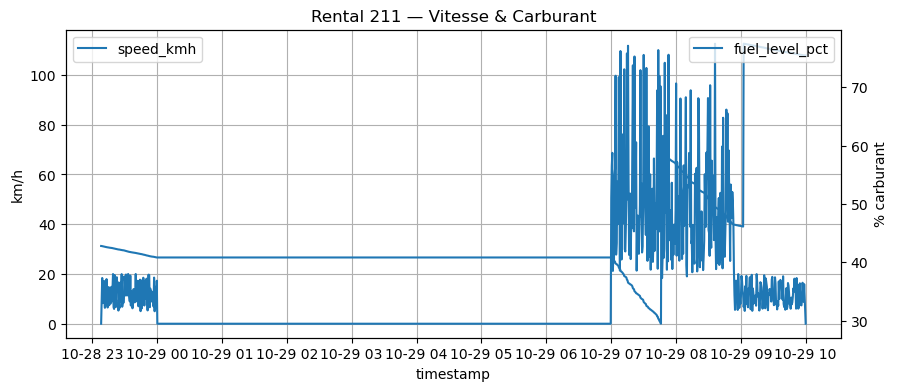

C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\2185723859.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med = gg.groupby('bin')['burn_pct_per_km'].median().dropna()


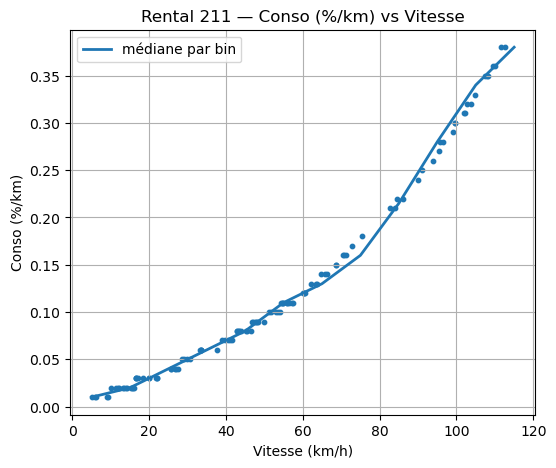

C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\2185723859.py:36: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  dt.iloc[0] = np.nan


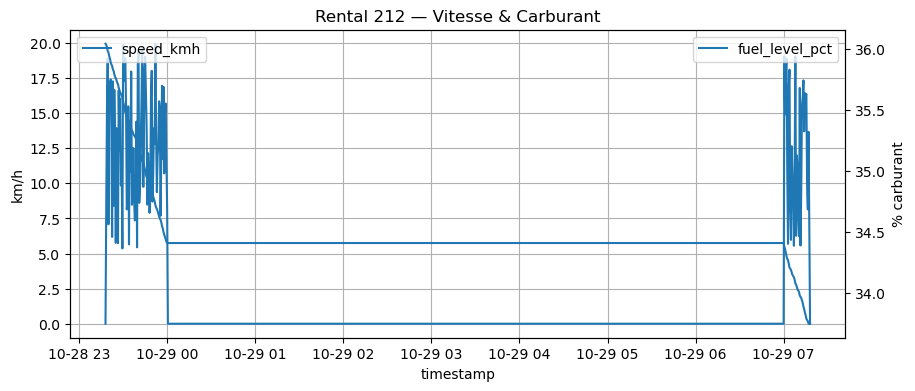

C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\2185723859.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med = gg.groupby('bin')['burn_pct_per_km'].median().dropna()


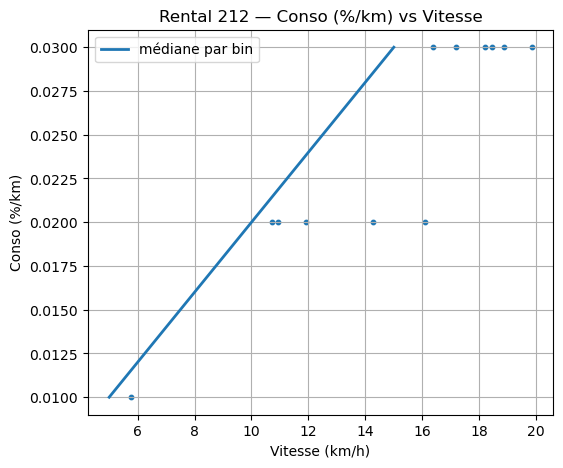

C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\2185723859.py:36: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  dt.iloc[0] = np.nan


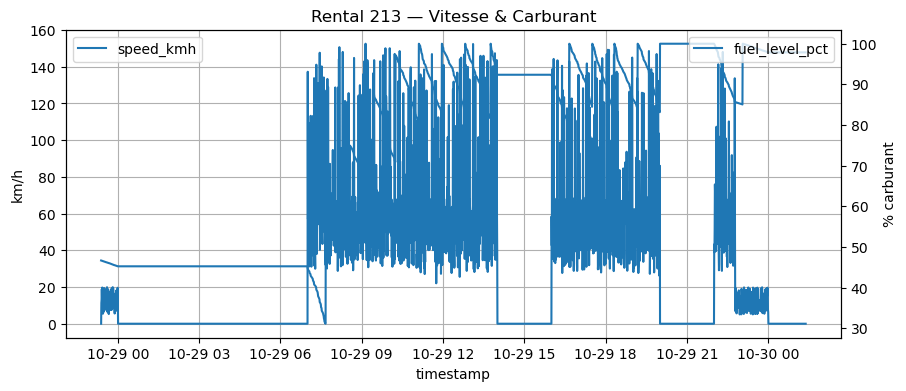

C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\2185723859.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med = gg.groupby('bin')['burn_pct_per_km'].median().dropna()


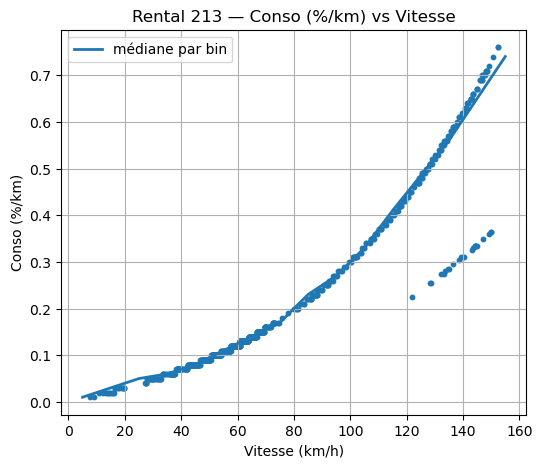

C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\2185723859.py:36: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  dt.iloc[0] = np.nan


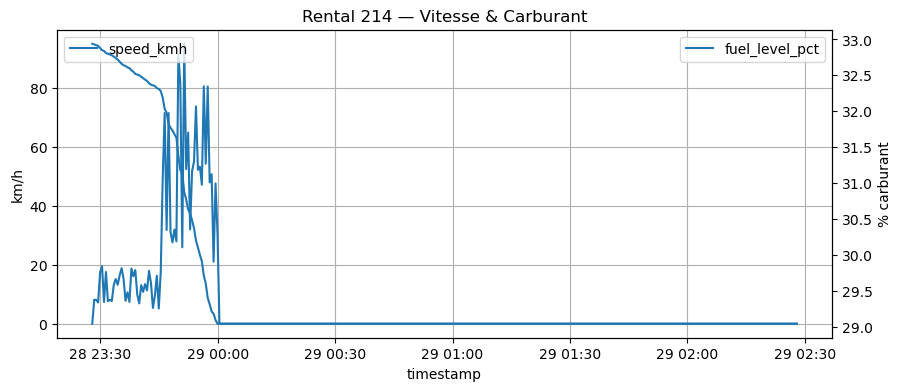

C:\Users\hamza\AppData\Local\Temp\ipykernel_11908\2185723859.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med = gg.groupby('bin')['burn_pct_per_km'].median().dropna()


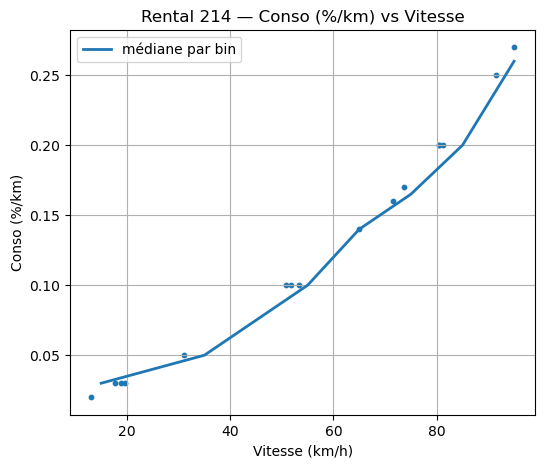

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================== Paramètres ==================
MIN_MOVE_SPEED = 5.0        # km/h — on considère "en mouvement" au-dessus
MIN_SEG_DIST_KM = 0.01      # km — ignorer mini-segments trop courts (bruit)
MAX_BURN_PCT_PER_KM = 5.0   # %/km — couper les valeurs extrêmes (refuel/bruit)

# ================== Préparation ==================
df = IOT_TELEMETRY.copy()
df.columns = [c.lower() for c in df.columns]
need = {'rental_id','timestamp','speed_kmh','fuel_level_pct','odometer_km'}
miss = need - set(df.columns)
if miss:
    raise ValueError(f"Colonnes manquantes: {miss}")

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp','speed_kmh','fuel_level_pct','odometer_km'])
df = df.sort_values(['rental_id','timestamp']).reset_index(drop=True)

# Option: limiter au top-N rentals pour ne pas faire trop de figures d'un coup
TOP_N_RENTALS = None  # ex: 3
rental_ids = df['rental_id'].drop_duplicates().tolist()
if isinstance(TOP_N_RENTALS, int):
    rental_ids = rental_ids[:TOP_N_RENTALS]

def per_rental_metrics(g: pd.DataFrame):
    g = g.sort_values('timestamp').copy()
    # Diff pas-à-pas
    dt = g['timestamp'].diff().dt.total_seconds()
    dkm = g['odometer_km'].diff()
    dfuel = g['fuel_level_pct'].diff()

    # Nettoyage première ligne
    dt.iloc[0] = np.nan
    dkm.iloc[0] = np.nan
    dfuel.iloc[0] = np.nan

    # Conso (positive si ça consomme)
    with np.errstate(divide='ignore', invalid='ignore'):
        burn_per_km = -dfuel / dkm  # %/km
        burn_per_h  = -dfuel / (dt/3600)  # %/h

    # Filtrage segments "utiles"
    moving = g['speed_kmh'] > MIN_MOVE_SPEED
    good_seg = moving & (dkm >= MIN_SEG_DIST_KM) & np.isfinite(burn_per_km)
    # Couper extrêmes (refuel/bruit)
    good_seg &= (burn_per_km >= 0) & (burn_per_km <= MAX_BURN_PCT_PER_KM)

    g['burn_pct_per_km'] = burn_per_km
    g['burn_pct_per_h'] = burn_per_h
    g['good_seg'] = good_seg

    return g

def plot_speed_and_fuel_over_time(g: pd.DataFrame, rid):
    # Figure 1: vitesse & fuel(%)
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(g['timestamp'], g['speed_kmh'], label='speed_kmh')
    ax1.set_xlabel('timestamp')
    ax1.set_ylabel('km/h')
    ax1.grid(True)
    ax1.set_title(f'Rental {rid} — Vitesse & Carburant')

    ax2 = ax1.twinx()
    ax2.plot(g['timestamp'], g['fuel_level_pct'], label='fuel_level_pct')
    ax2.set_ylabel('% carburant')

    # Légende simple (une par axe)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

def plot_burn_vs_speed_scatter(g: pd.DataFrame, rid):
    # Figure 2: scatter conso (%/km) vs vitesse
    gg = g[g['good_seg']].copy()
    if gg.empty:
        print(f"(Rental {rid}) Pas de segments valides pour le scatter.")
        return

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(gg['speed_kmh'], gg['burn_pct_per_km'], s=10)
    ax.set_title(f'Rental {rid} — Conso (%/km) vs Vitesse')
    ax.set_xlabel('Vitesse (km/h)')
    ax.set_ylabel('Conso (%/km)')
    ax.grid(True)

    # Ligne médiane par vitesse (binning) — optionnelle mais utile
    bins = np.arange(0, max(10, int(gg['speed_kmh'].max())+10), 10)  # tranches de 10 km/h
    gg['bin'] = pd.cut(gg['speed_kmh'], bins=bins, right=False, include_lowest=True)
    med = gg.groupby('bin')['burn_pct_per_km'].median().dropna()
    if not med.empty:
        # Convertir bins (Interval) en milieu de bin pour une courbe
        x = [(iv.left + iv.right)/2 for iv in med.index]
        ax.plot(x, med.values, linewidth=2, label='médiane par bin')
        ax.legend()

    plt.show()

# ================== Génération des graphiques ==================
for rid in rental_ids:
    g = df[df['rental_id'] == rid]
    if g.empty:
        continue
    g = per_rental_metrics(g)

    plot_speed_and_fuel_over_time(g, rid)
    plot_burn_vs_speed_scatter(g, rid)


### Speed Generation Rules

- **Idle Periods (Speed = 0)**: It is not realistic for vehicle speed to always be greater than 0. Incorporate idle times to simulate pauses, such as parking or overnight stops, where speed drops to 0 km/h.
- **Pause Frequency and Timing**: Users can and should have realistic pauses. Most pauses occur during common off-peak hours, such as:
  - 00:00–07:00 (overnight rest).
  - 14:00–16:00 (midday breaks, e.g., lunch or siesta).
  - Additional slots as needed (e.g., 20:00–22:00 for evenings), ensuring pauses align with daily human routines to avoid constant motion.